In [2]:
# Import libraries. 
# Generate images in the notebook
%matplotlib inline

import matplotlib.pyplot as plt
import collections
from collections import defaultdict
import gzip
import itertools
import numpy as np
import os
import time

from ipywidgets import interact
import bokeh
import bokeh.io
from bokeh.io import push_notebook
from bokeh.plotting import figure, show, save, output_notebook, output_file

# Import colour palettes for later on
from bokeh.palettes import Category20b
from bokeh.palettes import Purples
from bokeh.palettes import Greens
from bokeh.palettes import YlOrBr
from bokeh.palettes import YlOrRd
from bokeh.palettes import PuOr
from bokeh.palettes import RdGy

# Dimension reduction tools
from sklearn.decomposition import PCA as PCA
from sklearn.manifold import TSNE
import umap 

In [20]:
import os
# Specify your parent directory. This is where your 1KGP files are stored
data_dir = '/Users/kerem.uzel/JupDeneme/Aldabra/'


# These are the names of the files we use
vcf_name = 'ALL.wgs.nhgri_coriell_affy_6.20140825.genotypes_has_ped.vcf.gz'
pop_desc_name = '20131219.populations.tsv'
pop_file_name = 'affy_samples.20141118.panel'

vcf_file = os.path.join(data_dir, vcf_name)
population_description_file = os.path.join(data_dir, pop_desc_name)
population_file = os.path.join(data_dir, pop_file_name)

In [8]:
genotype_matrix=np.load('genotype_matrix.npy')
genotype_names=np.load('genotype_names.npy')
genotype_positions=np.load('genotype_positions.npy')

In [7]:
# Transpose the matrix
transposed_genotype_matrix = np.array(genotype_matrix).transpose()

In [14]:
population_by_individual = defaultdict(int)
individuals_by_population = defaultdict(list)  # A dictionary containing all the individuals in a given population

for line in open(population_file,'r'):
    split_line = line.split()
    if split_line[0] == 'sample':  # header line
        continue

    sample_name = split_line[0]
    population_name = split_line[1]
    population_by_individual[sample_name] = population_name
    individuals_by_population[population_name].append(sample_name) 

populations = list(individuals_by_population.keys())

In [18]:
# The path to the place where you put the population name file.
name_by_code = {}  # A dictionary giving the full name of each population code
pop_by_continent = {}  # A dictionary giving the code of each population within a continent  
continent_by_population = {}  # A dictionary giving the continent for each population code
for line in open(population_description_file,'r'):
    split_line = line.split('\t')
    if split_line[0] in ['Population Description','Total','']:  # header or footer
        continue
    name_by_code[split_line[1]] = split_line[0]
    continent_by_population[split_line[1]] = split_line[2]
    try: 
        pop_by_continent[split_line[2]].append(split_line[1])
    except KeyError:
        pop_by_continent[split_line[2]] = [split_line[1]]

continents = list(pop_by_continent.keys()) 
    
    
# Populations listed by continent
pops=[]
for continent in continents:
    pops.extend(pop_by_continent[continent])

In [19]:
# Assign colours to each population, roughly themed according to continent
# The Category20b palette has a bunch of groups of 4 shades in the same colour range
color_dict = {}
for i, cont in enumerate(continents): 
    for j, pop in enumerate(pop_by_continent[cont]):
        color_dict[pop] = Category20b[20][4*i+j%4]

# Colour palette above only really supports groups of 4 so we have to manually specify a few colours for the 5th/6th
# members of a group

color_dict['CHS'] = Purples[9][4]# purple
color_dict['STU'] = Greens[9][6] # green
color_dict['LWK'] = PuOr[11][-1] # brown
color_dict['MSL'] = PuOr[11][-2] # rusty brown
color_dict['YRI'] = PuOr[11][-3] # cappucino w/ extra milk (stirred)
color_dict['CEU'] = RdGy[11][-3]

In [21]:
for line in gzip.open(vcf_file,'rt'):
    if line.startswith("#"):
        if not line.startswith("##"):
            # Extract the individuals for the population, as a list of strings
            # Windows users may have trailing \n characters
            individuals = line.split()[9:]
            # Once we've extracted the individuals, we can exit the loops. 
            break

# Build a list of populations for each indiviudal in the vcf file
lspop = []
for ind in individuals:
    pop = population_by_individual[ind]
    if pop == 0:
        lspop.append("missing")
    else:
        lspop.append(pop)

        
indices_of_population_members = defaultdict(list)

for index,individual in enumerate(individuals):
    try:
        indices_of_population_members[population_by_individual[individual]].append(index)
    except KeyError: # We do not have population info for this individual
        continue

In [22]:
count = 0

for p in pop_by_continent:
    count+=len(pop_by_continent[p])
    
print(count)

26


In [23]:
imax = 0
imin = 200
for i in indices_of_population_members:
    imax = max(len(indices_of_population_members[i]),imax)
    imin = min(len(indices_of_population_members[i]),imin)
    
print(imax, imin)

183 104


In [24]:
# Dimensionality Reduction
# Calculate the PC axes
# This will take a few minutes
pca_full = PCA().fit(transposed_genotype_matrix)
# Project onto the PC axes
proj_pca = pca_full.fit_transform(transposed_genotype_matrix)


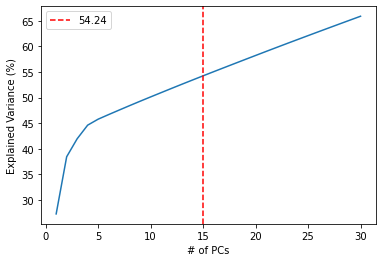

In [164]:
expl=pca_full.explained_variance_
plt.plot(np.arange(1,31),np.cumsum(expl)[:30])
plt.xlabel("# of PCs")
plt.ylabel("Explained Variance (%)")
plt.axvline(x = 15, color = 'r',linestyle = '--',label = str(round(np.cumsum(expl)[14],2)))
plt.legend()

In [25]:
# Project the genotype data matrix to two dimensions via t-SNE. This may take several minutes to run.
proj_tsne_gt = TSNE(n_components = 2).fit_transform(transposed_genotype_matrix)

In [26]:
# Project the genotype data matrix to two dimensions via UMAP
proj_umap_gt = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.5).fit_transform(transposed_genotype_matrix)

In [27]:
# Number of principal components to use
n_pc = 15

In [28]:
# Project the principal components via t-SNE to 2 dimensions.
proj_tsne_pca = TSNE(n_components=2).fit_transform(proj_pca[:,:n_pc])

In [29]:
# Project the principal components via UMAP to 2 dimensions.
proj_umap_pca = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.5).fit_transform(proj_pca[:,:n_pc])

In [30]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_std = sc.fit_transform(transposed_genotype_matrix)

cov_mat = np.cov(X_std)
eigenvals, eigen_vecs = np.linalg.eig(cov_mat)


In [125]:
deneme_eski=eigen_vecs.real*eigenvals.real

#print(deneme.shape)
#deneme_abs=abs(deneme)
#deneme_abs=deneme.real

In [136]:
deneme=np.empty((3450,15))
for i in range(15):
    deneme[:,i]=eigen_vecs.real[:,i]*eigenvals.real[i]

print(deneme.shape)

(3450, 15)


In [126]:
print(eigen_vecs[0:3,0])
print(eigen_vecs[0:3,1])
print(eigenvals[0:2])

print(deneme[0:3,0])
print(deneme[0:3,1])

print(eigen_vecs[0:3,0]*eigenvals[0])
print(eigen_vecs[0:3,1]*eigenvals[1])


print(deneme_eski[0:3,0])
print(deneme_eski[0:3,1])


[-0.01108018+0.j -0.01139363+0.j -0.01040302+0.j]
[-0.02658917+0.j -0.02874728+0.j -0.02324805+0.j]
[302.34283556+0.j 111.87817258+0.j]
[-3.35001231 -3.44478235 -3.14527934]
[-2.97474781 -3.21619297 -2.60094954]
[-3.35001231+0.j -3.44478235+0.j -3.14527934+0.j]
[-2.97474781+0.j -3.21619297+0.j -2.60094954+0.j]
[-3.35001231 -3.44478235 -3.14527934]
[-2.97474781 -3.21619297 -2.60094954]


In [137]:
# Project the eigenvectors via t-SNE to 2 dimensions.
#eigen_vecs_abs=abs(eigen_vecs)
eigen_vecs_abs=eigen_vecs.real
proj_tsne_eig = TSNE(n_components=2).fit_transform(eigen_vecs_abs[:,:n_pc])

In [138]:
# Project the eigenvectors via UMAPto 2 dimensions.
proj_umap_eig = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.5).fit_transform(eigen_vecs_abs[:,:n_pc])

In [139]:
# Project the eigenvectors via t-SNE to 2 dimensions.
proj_tsne_deneme = TSNE(n_components=2).fit_transform(deneme[:,:n_pc])

In [140]:
# Project the eigenvectors via UMAPto 2 dimensions.
proj_umap_deneme = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.5).fit_transform(deneme[:,:n_pc])

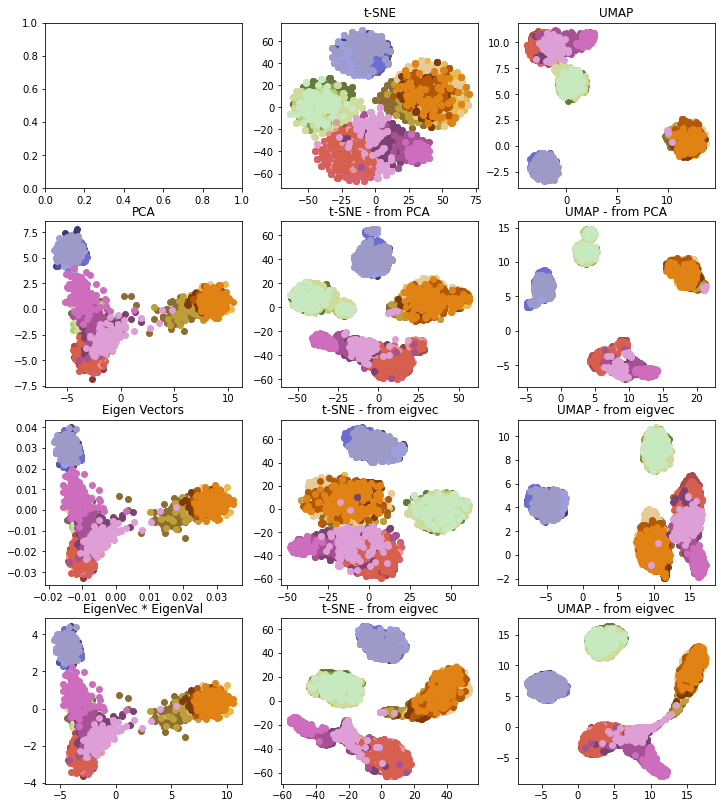

In [145]:
fig, axs = plt.subplots(4, 3,figsize=(12, 14))
dim1 = 0
dim2 = 1




#axs[0, 1].plot(x, y, 'tab:orange')
axs[0, 1].set_title('t-SNE')
# Use the UMAP projection of the genotype data
dset = proj_tsne_gt
for cont in continents: 
    for pop in pop_by_continent[cont]:
        projections_within_population = dset[indices_of_population_members[pop]]
        axs[0,1].scatter(projections_within_population[:,dim1], projections_within_population[:,dim2], label=name_by_code[pop]
                , color = color_dict[pop])
        
#axs[0,1].legend(loc="upper left")

#axs[1, 0].plot(x, -y, 'tab:green')
axs[0, 2].set_title('UMAP')
dset = proj_umap_gt
for cont in continents: 
    for pop in pop_by_continent[cont]:
        projections_within_population = dset[indices_of_population_members[pop]]
        axs[0,2].scatter(projections_within_population[:,dim1], projections_within_population[:,dim2], label=name_by_code[pop]
                , color = color_dict[pop])
        


#axs[1, 1].plot(x, -y, 'tab:red')
axs[1, 0].set_title('PCA')
dset = proj_pca
for cont in continents: 
    for pop in pop_by_continent[cont]:
        projections_within_population = dset[indices_of_population_members[pop]]
        axs[1,0].scatter(projections_within_population[:,dim1], projections_within_population[:,dim2], label=name_by_code[pop]
                , color = color_dict[pop])
        


#axs[1, 1].plot(x, -y, 'tab:red')
axs[1, 1].set_title('t-SNE - from PCA')
dset = proj_tsne_pca
for cont in continents: 
    for pop in pop_by_continent[cont]:
        projections_within_population = dset[indices_of_population_members[pop]]
        axs[1,1].scatter(projections_within_population[:,dim1], projections_within_population[:,dim2], label=name_by_code[pop]
                , color = color_dict[pop])
        


#axs[1, 1].plot(x, -y, 'tab:red')
axs[1, 2].set_title('UMAP - from PCA')
dset = proj_umap_pca
for cont in continents: 
    for pop in pop_by_continent[cont]:
        projections_within_population = dset[indices_of_population_members[pop]]
        axs[1,2].scatter(projections_within_population[:,dim1], projections_within_population[:,dim2], label=name_by_code[pop]
                , color = color_dict[pop])
        


#axs[1, 1].plot(x, -y, 'tab:red')
axs[2, 0].set_title('Eigen Vectors')
dset = eigen_vecs
for cont in continents: 
    for pop in pop_by_continent[cont]:
        projections_within_population = dset[indices_of_population_members[pop]]
        axs[2,0].scatter(projections_within_population[:,dim1], projections_within_population[:,dim2], label=name_by_code[pop]
                , color = color_dict[pop])
        


#axs[1, 1].plot(x, -y, 'tab:red')
axs[2, 1].set_title('t-SNE - from eigvec')
dset = proj_tsne_eig
for cont in continents: 
    for pop in pop_by_continent[cont]:
        projections_within_population = dset[indices_of_population_members[pop]]
        axs[2,1].scatter(projections_within_population[:,dim1], projections_within_population[:,dim2], label=name_by_code[pop]
                , color = color_dict[pop])
        


#axs[1, 1].plot(x, -y, 'tab:red')
axs[2, 2].set_title('UMAP - from eigvec')
dset = proj_umap_eig
for cont in continents: 
    for pop in pop_by_continent[cont]:
        projections_within_population = dset[indices_of_population_members[pop]]
        axs[2,2].scatter(projections_within_population[:,dim1], projections_within_population[:,dim2], label=name_by_code[pop]
                , color = color_dict[pop])
        
#axs[1, 1].plot(x, -y, 'tab:red')
axs[3, 0].set_title('EigenVec * EigenVal')
dset = deneme
for cont in continents: 
    for pop in pop_by_continent[cont]:
        projections_within_population = dset[indices_of_population_members[pop]]
        axs[3,0].scatter(projections_within_population[:,dim1], projections_within_population[:,dim2], label=name_by_code[pop]
                , color = color_dict[pop])
        


#axs[1, 1].plot(x, -y, 'tab:red')
axs[3, 1].set_title('t-SNE - from eigvec')
dset = proj_tsne_deneme
for cont in continents: 
    for pop in pop_by_continent[cont]:
        projections_within_population = dset[indices_of_population_members[pop]]
        axs[3,1].scatter(projections_within_population[:,dim1], projections_within_population[:,dim2], label=name_by_code[pop]
                , color = color_dict[pop])
        


#axs[1, 1].plot(x, -y, 'tab:red')
axs[3, 2].set_title('UMAP - from eigvec')
dset = proj_umap_deneme
for cont in continents: 
    for pop in pop_by_continent[cont]:
        projections_within_population = dset[indices_of_population_members[pop]]
        axs[3,2].scatter(projections_within_population[:,dim1], projections_within_population[:,dim2], label=name_by_code[pop]
                , color = color_dict[pop])
        
plt.savefig('PCA_tSNE_UMAP_tutorial.png')
plt.show()

